# Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

## Loading the data

In [1]:
# load in packages
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from test_results import test_results, score
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
import xgboost as xgb
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [2]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [3]:
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


## EDA

In [4]:
# check for missing data
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [5]:
# check for duplicate data
train_data.duplicated().sum()

0

In [6]:
# check for imbalance data
train_data.groupby(['Promotion','purchase'])[['ID']].count()

ID
Promotion purchase       
No        0         41851
          1           319
Yes       0         41643
          1           721

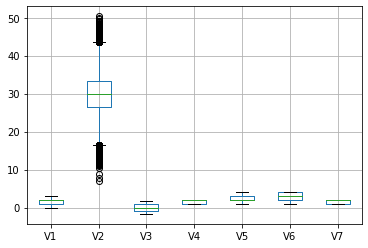

In [7]:
#check if data valid by visualize the distribution of values
features = train_data.iloc[:,3:].columns
train_data[features].boxplot();

#### Note

Our data looks clean and ready to use but the data also imbalanced and need to apply some technique to make a good use out of it.

## Baseline (send promotion to every customer)

In [8]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''   
    
    result = []
    
    for i in range(df.shape[0]):
        result.append('Yes')
        
    promotion = np.array(result)
    
    return promotion

In [9]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.

We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

#### Note

If we blindly send promotion to everyone, Starbucks will take a hugh loss in this campaign.

## Uplift Model

The most common approach of uplift model is training a predictive model by predict only for individuals who received promotions and purchased.
In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. 
In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. This model surprisingly performed relatively well for this dataset despite the fact that this model is very simple model.

In [10]:
#generate labels
response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [11]:
#generate features
X = train_data[features]
y = train_data['response']

In [12]:
#split data into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)

In [13]:
#upsampling only on the train data with SMOTE method
smote = SMOTE(random_state=42)

X_train_upsamp, y_train_upsamp = smote.fit_resample(X_train, y_train)

X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

y_train_upsamp = pd.Series(y_train_upsamp)

In [14]:
#check upsampling data
y_train_upsamp.value_counts()

0.0    67047
1.0    67047
Name: response, dtype: int64

In [15]:
#create evaluation dataset
eval_set = [(X_train_upsamp, y_train_upsamp), (X_valid, y_valid)]

In [16]:
#train xgboost model with no tuning
model = xgb.XGBClassifier(learning_rate = 0.1, seed = 42)
model.fit(X_train_upsamp, y_train_upsamp, eval_set=eval_set,
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.72327	validation_1-auc:0.55436
[1]	validation_0-auc:0.74085	validation_1-auc:0.55391


/Users/panja/opt/anaconda3/envs/rnd/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.74216	validation_1-auc:0.55776
[3]	validation_0-auc:0.75055	validation_1-auc:0.55912
[4]	validation_0-auc:0.76476	validation_1-auc:0.55558
[5]	validation_0-auc:0.77155	validation_1-auc:0.56874
[6]	validation_0-auc:0.77726	validation_1-auc:0.57253
[7]	validation_0-auc:0.79233	validation_1-auc:0.56988
[8]	validation_0-auc:0.79753	validation_1-auc:0.57535
[9]	validation_0-auc:0.80618	validation_1-auc:0.57583
[10]	validation_0-auc:0.81996	validation_1-auc:0.57662
[11]	validation_0-auc:0.82437	validation_1-auc:0.57244
[12]	validation_0-auc:0.82921	validation_1-auc:0.57129
[13]	validation_0-auc:0.83219	validation_1-auc:0.57826
[14]	validation_0-auc:0.83491	validation_1-auc:0.57481
[15]	validation_0-auc:0.84038	validation_1-auc:0.57397
[16]	validation_0-auc:0.84422	validation_1-auc:0.57396
[17]	validation_0-auc:0.85138	validation_1-auc:0.56932
[18]	validation_0-auc:0.85377	validation_1-auc:0.56956
[19]	validation_0-auc:0.85495	validation_1-auc:0.57229
[20]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

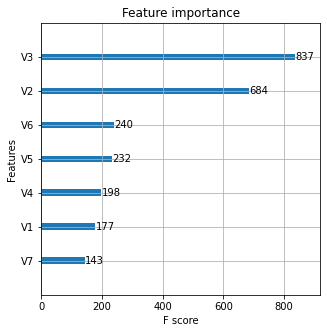

In [17]:
#plot features importance
fig, ax = plt.subplots(figsize=(5, 5));
plot_importance(model, ax=ax);

In [18]:
#show confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(y_valid, valid_pred)

array([[12657,  4109],
       [   87,    54]])

In [19]:
#more detail on F1 score
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.86     16766
         1.0       0.01      0.38      0.03       141

    accuracy                           0.75     16907
   macro avg       0.50      0.57      0.44     16907
weighted avg       0.98      0.75      0.85     16907



In [20]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [21]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0203.

Your nir with this strategy is 260.00.

We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02031103678929766, 260.0)

As we can see, our strategy outperforms the optimal strategy devised by Udacity. Our incremental response rate is 2.03% while our net incremental revenue is $260.00 
This means that my strategy was more targeted (and thus more efficient, as more people responded), and reached a large enough audience to generate a lot of incremental revenue.

Although this approach was devised with a XGBoost, we could test different classification models (Random Forest, Logistic Regression...) and see which yields the best results.